In [1]:
# only for macbook with AMD GPU
import os
import plaidml.keras
plaidml.keras.install_backend()
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"


In [2]:
from __future__ import print_function
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical
import cv2
import os
from tqdm.notebook import tqdm
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
from keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model

In [4]:
!pwd all_in_one_MIT_BIH_DATASET_32_5_2021.csv

zsh:pwd:1: too many arguments


In [3]:
data = pd.read_csv('./../New Folder With Items/MIT_BIH_DATASET_Resampled_Filltered_6_2021.csv')

In [4]:
data.head()

,1,2,3,4,5,6,7,8,9,10,...,292,293,294,295,296,297,298,299,300,301
0,0.239643,0.164720,0.137425,0.084942,0.153273,0.184037,0.238504,0.157602,0.127725,0.120196,...,0.013269,-0.090593,-0.083783,-0.010214,0.003538,-0.048281,0.013559,-0.054481,-0.037631,0.0
1,-0.019156,0.056494,0.085993,0.016801,-0.018386,-0.057010,-0.068422,0.026895,-0.014682,-0.062788,...,-0.001479,-0.108656,-0.058153,0.001199,-0.007415,0.059003,-0.032712,-0.101004,-0.121043,0.0
2,-0.070916,-0.072735,-0.068566,-0.088535,-0.195064,-0.250222,-0.174585,-0.172860,-0.113858,-0.149651,...,0.060226,0.045062,0.087087,0.094336,0.015158,0.011150,0.037077,0.060055,0.027918,0.0
3,-0.045036,-0.015860,-0.051289,0.046698,0.046348,-0.004921,-0.084028,-0.172101,-0.150082,-0.089753,...,0.006724,0.015977,0.054514,0.133155,0.123297,0.076452,0.054817,-0.004272,-0.099234,0.0
4,0.006723,0.028755,0.040530,-0.042902,-0.081792,-0.152608,-0.105317,-0.062382,-0.040877,-0.144280,...,0.135370,0.078398,0.127388,0.167807,0.151218,0.076355,0.054625,0.005897,0.060152,0.0


In [ ]:
!pip install biosppy


     |████████████████████████████████| 92kB 5.4MB/s 


In [5]:
from biosppy.signals import ecg

In [6]:
from scipy import signal


In [7]:
data['301'].value_counts()

0.0    8408
3.0    6771
1.0    6068
2.0    3983
4.0    1970
Name: 301, dtype: int64

In [8]:
print(keras.__version__)

2.2.4-tf


In [9]:
data_new = data.to_numpy()
print(data_new.shape)

(27200, 301)


In [10]:

data, labels = data_new[:, :-1], data_new[:, -1]
print(data.shape, labels.shape)



(27200, 300) (27200,)


In [11]:
from sklearn.utils import class_weight


In [12]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(labels),
                                                 labels)

In [13]:
class_weights

array([0.64700285, 0.89650626, 1.36580467, 0.80342638, 2.76142132])

In [14]:
def scale_data(data, lower=0, upper=1024):
    '''scales passed sequence between thresholds

    Function that scales passed data so that it has specified lower 
    and upper bounds.
    
    Parameters
    ----------
    data : 1-d array or list
        Sequence to be scaled

    lower : int or float
        lower threshold for scaling
        default : 0

    upper : int or float
        upper threshold for scaling
        default : 1024

    Returns
    -------
    out : 1-d array
        contains scaled data

    Examples
    --------
    When passing data without further arguments to the function means it scales 0-1024
    
    >>> x = [2, 3, 4, 5]
    >>> scale_data(x)
    array([   0.        ,  341.33333333,  682.66666667, 1024.        ])

    Or you can specify a range:

    >>> scale_data(x, lower = 50, upper = 124)
    array([ 50.        ,  74.66666667,  99.33333333, 124.        ])
    '''

    rng = np.max(data) - np.min(data)
    minimum = np.min(data)
    data = (upper - lower) * ((data - minimum) / rng) + lower
    return data

In [15]:
sampling_rate = float(300)
# filter signal
order = int(0.3 * sampling_rate)
filter_data = np.zeros((len(data),len(data[0])))
for i, (xrow, yrow) in enumerate(zip(data, labels)):
  filtered, _, _ = ecg.st.filter_signal(signal=xrow,
                                      ftype='FIR',
                                      band='bandpass',
                                      order=order,
                                      frequency=[3, 45],
                                      sampling_rate=sampling_rate)
    
  # print(filtered)
  scaled = scale_data(filtered,lower=0, upper=1)
  filter_data[i] = scaled

***adding Filters***

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(filter_data, labels, test_size=0.40, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.50, random_state=42)

In [18]:
np.unique(y_valid, return_counts=True
          )

(array([0., 1., 2., 3., 4.]), array([1673, 1206,  813, 1371,  377]))

In [19]:
np.unique(y_train, return_counts=True
          )

(array([0., 1., 2., 3., 4.]), array([5048, 3650, 2375, 4058, 1189]))

In [20]:
np.unique(y_test, return_counts=True)


(array([0., 1., 2., 3., 4.]), array([1687, 1212,  795, 1342,  404]))

In [21]:
X_train.shape

(16320, 300)

In [22]:
y_valid.shape

(5440,)

In [23]:
y_test.shape

(5440,)

In [24]:

import keras
import pandas as pd
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
from keras import regularizers

In [25]:
model = None

In [26]:
dropout_perc = 0.2
l2_reg = 0.01
model = Sequential()
model.add(LSTM(300, return_sequences=True,input_shape=(1,300)))
model.add(Dropout(dropout_perc))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(dropout_perc))
model.add(LSTM(100,return_sequences=True))
model.add(Dropout(dropout_perc))
model.add(Dense(64, activation='relu'))
model.add(Dropout(dropout_perc))
model.add(Dense(5, activation='softmax', kernel_regularizer=regularizers.l2(l2_reg)))
print(model.summary())

INFO:plaidml:Opening device "metal_amd_radeon_pro_5300m.0"


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 300)            721200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 300)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 100)            160400    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 100)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 100)            80400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 100)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1, 64)             6464      
__________

In [ ]:
!pip install livelossplot

In [27]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [28]:
y_train.shape

(16320,)

In [29]:
y_valid.shape

(5440,)

In [30]:
X_train = np.expand_dims(X_train, axis=1)
X_valid = np.expand_dims(X_valid, axis=1)

In [31]:
y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)

In [32]:
y_train = np.expand_dims(y_train, axis=1)
y_valid = np.expand_dims(y_valid, axis=1)

In [33]:
from livelossplot import PlotLossesKeras
import tensorflow as tf

In [85]:
mincp_save =keras.callbacks.ModelCheckpoint('./LSTMbestEpochMin.hdf5', save_best_only=True, monitor='val_loss', mode='min')
maxcp_save =keras.callbacks.ModelCheckpoint('./LSTMbestEpochMax.hdf5', save_best_only=True, monitor='val_acc', mode='max')
callbacks = [mincp_save,maxcp_save,tf.keras.callbacks.TensorBoard(log_dir='./logs'),tf.keras.callbacks.EarlyStopping(patience=10)]

In [40]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    batch_size=32,
    class_weight=class_weights,
    callbacks=callbacks,
    epochs=50)

Train on 16320 samples, validate on 5440 samples
Epoch 1/50
16320/16320 [==============================] - 11s 662us/step - loss: 0.8348 - acc: 0.6885 - val_loss: 0.4389 - val_acc: 0.8697
Epoch 2/50
16320/16320 [==============================] - 9s 581us/step - loss: 0.4357 - acc: 0.8673 - val_loss: 0.2975 - val_acc: 0.9090
Epoch 3/50
16320/16320 [==============================] - 10s 585us/step - loss: 0.3301 - acc: 0.9034 - val_loss: 0.2477 - val_acc: 0.9285
Epoch 4/50
16320/16320 [==============================] - 10s 592us/step - loss: 0.2642 - acc: 0.9232 - val_loss: 0.1848 - val_acc: 0.9496
Epoch 5/50
16320/16320 [==============================] - 10s 584us/step - loss: 0.2288 - acc: 0.9330 - val_loss: 0.1555 - val_acc: 0.9592
Epoch 6/50
16320/16320 [==============================] - 10s 587us/step - loss: 0.1985 - acc: 0.9450 - val_loss: 0.1845 - val_acc: 0.9489
Epoch 7/50
16320/16320 [==============================] - 10s 591us/step - loss: 0.1845 - acc: 0.9495 - val_loss: 0.16

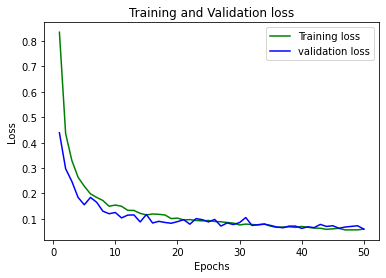

In [86]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,51)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

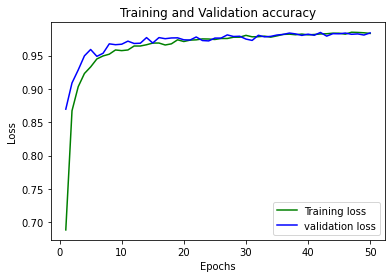

In [88]:
loss_train = history.history['acc']
loss_val = history.history['val_acc']
epochs = range(1,51)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [94]:
min(history.history['val_loss'])

0.05990186599357163

In [41]:
model.load_weights('./LSTMbestEpochMin.hdf5')

In [42]:
test_data = np.expand_dims(X_test, axis=1)


In [43]:
test_lables = to_categorical(y_test)
test_lables_dims = np.expand_dims(test_lables, axis=1)


In [44]:
len(test_data)

5440

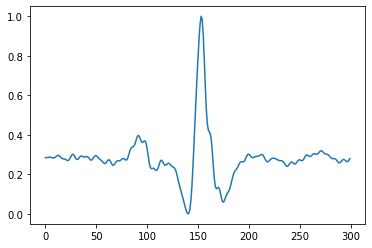

In [57]:
plt.plot(X_test[0])

In [59]:
import ecg_plot

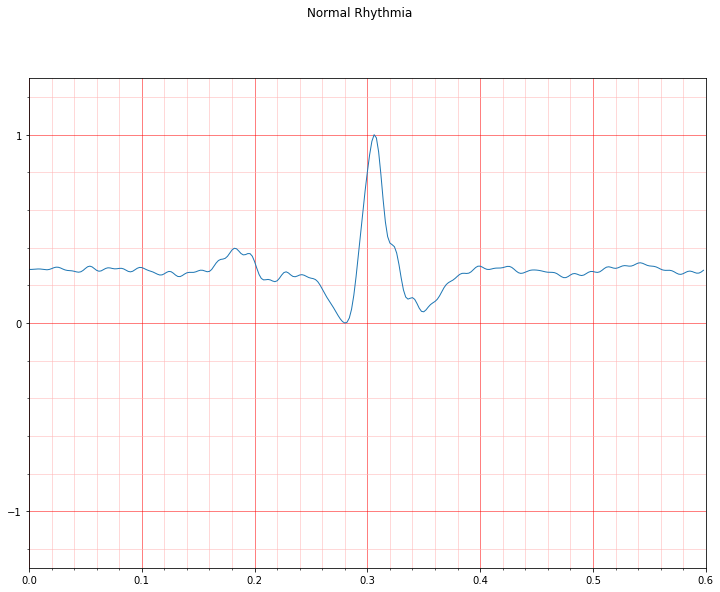

In [84]:
ecg_plot.plot_1(X_test[0],fig_height=10,fig_width = 10,line_w=1,ecg_amp=1.3,timetick = 0.1, title = 'Normal Rhythmia')
ecg_plot.show()

In [45]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_data, test_lables_dims)
print("test loss, test acc:", results)

Evaluate on test data
5440/5440 [==============================] - 1s 228us/step
test loss, test acc: [0.08124959180131555, 0.9799632352941177]


In [46]:
from sklearn.metrics import accuracy_score


In [47]:

results = model.predict_classes(test_data)

In [48]:
y_test

array([0., 2., 1., ..., 0., 3., 3.])

In [49]:
accuracy_score(y_test,results) 

0.9799632352941177

In [56]:
len(results)

5440

In [57]:
type(test_lables_dims)

numpy.ndarray

In [50]:
valloss = min(history.history['val_loss'])

In [51]:
valloss

0.05990186599357163

In [52]:
minval = (history.history['val_loss']).index(valloss)

Text(0, 0.5, 'loss')

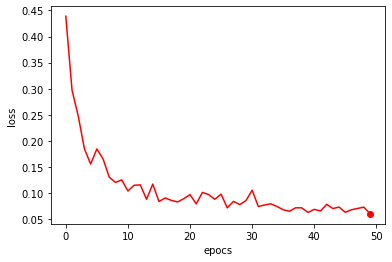

In [53]:
plt.plot(history.history['val_loss'],markevery=[minval],marker='o', color='r')
plt.xlabel("epocs")
plt.ylabel("loss")

In [62]:
history.history['val_acc']

[0.9590073529411764,
 0.9735294117647059,
 0.9764705882352941,
 0.9795955882352941,
 0.9806985294117647,
 0.9794117647058823,
 0.9803308823529412,
 0.9814338235294118,
 0.9761029411764706,
 0.9818014705882353]

Text(0, 0.5, 'accuracy')

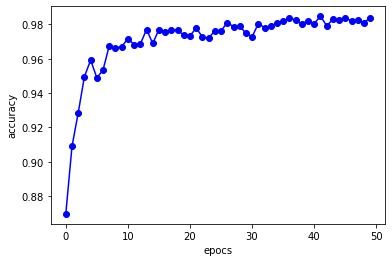

In [54]:
plt.plot(history.history['val_acc'],marker='o', color='b')
plt.xlabel("epocs")
plt.ylabel("accuracy")

In [55]:
model.save('LSTM_50_E_21_jun_Final.h5')

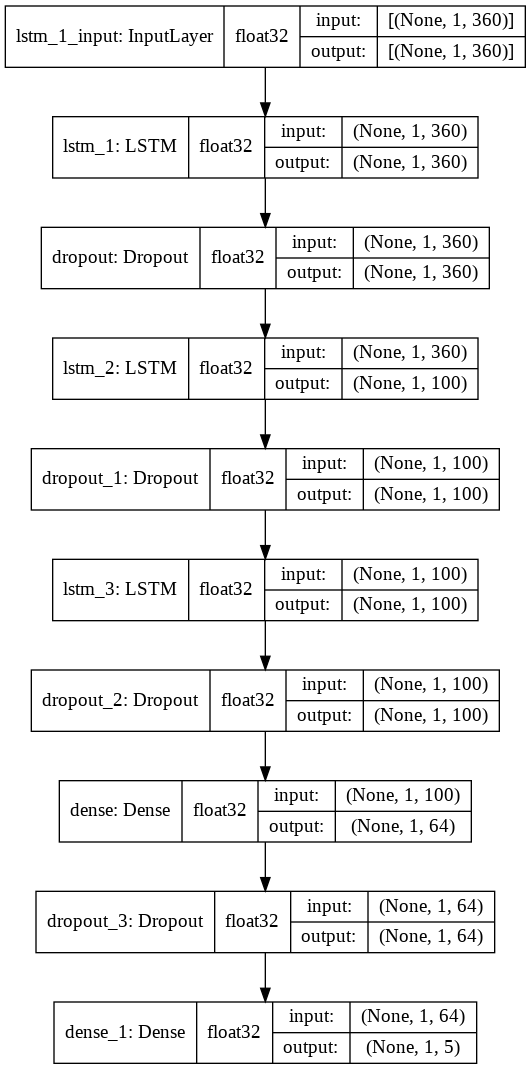

In [ ]:
plot_model(model, to_file='model_plot.png', rankdir='TB',show_dtype=True,show_shapes=True, show_layer_names=True)